# OTONOM ARAÇ SİMÜLASYON PROJESİ ~ Eda Menekşeyurt

Otonom sürüş kavramı, bir aracın insan müdahalesine ihtiyaç duymadan kendini yönlendirebilmesi, çevrelerindeki engelleri algılaması ve trafiğe uygun bir şekilde hareket edebilmesini ifade eder. Bu çalışmanın amacı; Python programlama dili ve kütüphaneleri, Yolo transformer modeli ve Faster RCNN ResNet-50 modeli kullanılarak şerit takip, nesne tespit, trafik ışığı ve renginin algılanması, hız tespit gibi otonom araçların en temel özelliklerinin görüntü işleme teknikleri ile tespit edilmesidir. 

### PROJEDE KULLANILAN KÜTÜPHANELER VE TEKNOLOJİLER

* Python Programlama Dili
* OpenCV
* PIL
* Numpy
* Torchvision
* YOLOv8
* Faster RCNN ResNet-50
* Shutil
* Os
* Subprocess
* Moviepy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import os
import shutil
import subprocess
from moviepy.editor import VideoFileClip, concatenate_videoclips, CompositeVideoClip
import moviepy.editor as mp

In [ ]:
class OtonomSurus:
    def __init__(self):
        # Onceden egitilmis modelin yuklenmesi
        self.model = fasterrcnn_resnet50_fpn(pretrained=True)
        self.model.eval()
        self.yolo_model = "yolov8m.pt"

Bu kısımda gerekli kütüphanelerin import edilmesi ve class yapısının oluşturulması sağlanmıştır.

#### TRAFİK IŞIĞI VE RENGİNİN TESPİTİ

In [ ]:
# Görüntünün pytorch icin uygun hale getirilmesi
    def transform_image(self, image):
        transform = T.Compose([T.ToTensor()])
        transformed_image = transform(image).unsqueeze(0)
        return transformed_image

In [ ]:
# Görüntünün renk analizinin yapılması (histogram değerinin hesaplanması)
    def renk_dagilim_analizi(self, image):
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist

In [ ]:
# Görüntülerin renk analizlerinin (histogram değerlerinin) karsilastirilmasi
    def renk_analiz_karsilastirma(self, hist1, hist2, hist3):
        diff1 = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
        diff2 = cv2.compareHist(hist2, hist3, cv2.HISTCMP_CHISQR)
        diff3 = cv2.compareHist(hist1, hist3, cv2.HISTCMP_CHISQR)
        return diff1, diff2, diff3

In [ ]:
    def trafik_isigi_tespit(self, video):
        # Video dosyasinin okunmasi
        cap = cv2.VideoCapture(video)

        # Video ozelliklerinin alinmasi
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Video yazicilarinin tanimlanmasi
        output_path = "trafik_isigi_tespit.mp4"
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

        while cap.isOpened():
            # Bir sonraki frame'in alinmasi
            ret, frame = cap.read()
            if not ret:
                break

            # Frame'in PIL icin uygun hale donusturulmesi
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # Goruntunun pytorch icin yazilan fonksiyonla islenmesi
            image_tensor = self.transform_image(image)

            # resnet ile nesne tespitinin yapilmasi
            with torch.no_grad():
                prediction = self.model(image_tensor)

            # Tespit edilen trafik isiklarinin ve doğruluk degerlerinin kaydedilmesi
            traffic_lights = [(box, score) for box, label, score in
                              zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']) if
                              label == 10]

            image_np = np.array(frame)

            if traffic_lights:
                # Frame'in renk uzayinin tekrar RGB'ye donusturulmesi
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                text_content = ""

                for box, score in traffic_lights:
                    if score > 0.90:
                        # Trafik isiginin 3 parcaya bolunmesi
                        x1 = int(box[0])
                        y1 = int(box[1])
                        x2 = int(box[2])
                        y2 = int(box[3])
                        third_height = (y2 - y1) // 3

                        part1 = frame_rgb[y1:y1 + third_height, x1:x2, :]
                        part2 = frame_rgb[y1 + third_height:y1 + 2 * third_height, x1:x2, :]
                        part3 = frame_rgb[y1 + 2 * third_height:y2, x1:x2, :]

                        # Parcaların renk analizinin yapilmasi
                        hist1 = self.renk_dagilim_analizi(part1)
                        hist2 = self.renk_dagilim_analizi(part2)
                        hist3 = self.renk_dagilim_analizi(part3)

                        # Parcaların renk analizlerinin karsilastirilmasi
                        diff1, diff2, diff3 = self.renk_analiz_karsilastirma(hist1, hist2, hist3)

                        # Trafik isiginin renginin tespit edilmesi
                        listee = [diff1, diff2, diff3]
                        sorted_listee = sorted(listee, reverse=True)

                        # Trafik isigi bilgilerinin kutunun yanina yazdirilmasi
                        font_scale = 1.5
                        if (sorted_listee[0] == diff1 and sorted_listee[1] == diff3) or (
                                sorted_listee[0] == diff3 and sorted_listee[1] == diff1):
                            color_light = "Kirmizi"
                            text = f"{score:.2f} {color_light}"
                            cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255),
                                          2)
                            cv2.putText(image_np, text, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX,
                                        font_scale,
                                        (0, 0, 255), 2)

                        elif (sorted_listee[0] == diff2 and sorted_listee[1] == diff1) or (
                                sorted_listee[0] == diff1 and sorted_listee[1] == diff2):
                            color_light = "Sari"
                            text = f"{score:.2f} {color_light}"
                            cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                                          (0, 255, 255), 2)
                            cv2.putText(image_np, text, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX,
                                        font_scale,
                                        (0, 255, 255), 2)

                        elif (sorted_listee[0] == diff2 and sorted_listee[1] == diff3) or (
                                sorted_listee[0] == diff3 and sorted_listee[1] == diff2):
                            color_light = "Yesil"
                            text = f"{score:.2f} {color_light}"
                            cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0),
                                          2)
                            cv2.putText(image_np, text, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX,
                                        font_scale,
                                        (0, 255, 0), 2)

                        else:
                            color_light = "Belirlenemedi"
                            text = f"{score:.2f} {color_light}"
                            cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 0),
                                          2)
                            cv2.putText(image_np, text, (int(box[0]), int(box[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX,
                                        font_scale,
                                        (0, 0, 0), 2)

            # Videoya frame'in yazilmasi
            out.write(image_np)


        # Videolarin serbest birakilmasi
        cap.release()
        out.release()
        cv2.destroyAllWindows()


Trafik ışığı tespit edilirken Faster RCNN ResNet-50 modeli kullanılmıştır. Input olarak verilen video frame frame işlenerek ResNet-50 modeli ile trafik ışıkları tespit edilir, tespit edilen her trafik ışığının doğruluk skoru kontrol edilir. Doğruluk skoru 0.90'dan büyükse trafik ışığı kutusu yatay olarak 3 eşit parçaya bölünür, 3 parçanın histogram değerleri hesaplanır ve birbirleri ile karşılaştırılır. Farklılığı en çok olan parça 1. parça ise "Kırmızı", 2. parça ise "Sarı", 3. parça ise "Yeşil", eğer bu durumlar söz konusu değilse "Belirlenemedi" olarak etiketlenir ve belirlenen renkte trafik ışığı video üzerinde çizdirilir ve rengi yazdırılır. Renk tespitinin konuma ve histogram değerlerine bağlı olarak belirlenmesinin sebebi; her zaman renk tonlarının aynı görünmemesidir. Sadece renk tonlarına bağlı renk tespiti yapıldığında özellikle "sarı" ışığın "kırmızı" olarak yanlış etiketlendiği görülmüş ve konum-histogram değerlerine dayalı tespit yapılması düşünülmüştür. Sonuç olarak trafik ışıklarının tespit edildiği bir mp4 dosyası kaydedilir.

#### NESNE TESPİT

In [ ]:
    def nesne_tespit(self, input_video):
        # YOLO ile nesne tespit yapilmasi
        yolo_process = subprocess.run(
            f"yolo detect predict model={self.yolo_model} source={input_video}",
            shell=True,
            capture_output=True
        )

        # Output videosunun konumunun bulunmasi
        output_directory = "runs/detect/predict"
        output_video = None
        for root, dirs, files in os.walk(output_directory):
            for file in files:
                if file.endswith(".avi"):  # avi uzantili output videosunun bulunmasi
                    output_video = os.path.join(root, file)
                    # avi uzantisinin mp4'e donusturulmesi ve bulunulan dizine kaydedilmesi
                    clip = mp.VideoFileClip(output_video)
                    yeni_ad = "otonom.mp4"
                    clip.write_videofile(yeni_ad, codec="libx264", audio_codec="aac")

        shutil.move(output_video, os.path.join(os.getcwd(), os.path.basename(output_video)))
        shutil.rmtree("runs")

Input olarak verilen videodaki nesnelerin hızlı ve yüksek doğruluk skorları ile tespit edilmesi için YOLOv8 transformer modeli kullanılmıştır. YOLO, nesne algılama ve sınıflandırma için tek bir CNN ağı kullanan, büyük ve geniş veri setleriyle eğitilmiş hazır bir derin öğrenme modelidir. Sonuç olarak nesnelelerin tespit edildiği bir mp4 dosyası kaydedilir.

#### ŞERİT TESPİT

In [ ]:
# Şeritlerin sadece yolda tespit edilmesini sağlayacak bir bölge kısıtlması
    def bolge_kisitlamasi(self, frame):
        height = frame.shape[0]
        width = frame.shape[1]
        koseler = np.array([[(0, height), (width*0.1, 0.90*height), (width/5*4, 0.90*height), (width, height)]], dtype=np.int32)
        kisitlama = np.zeros_like(frame)
        cv2.fillPoly(kisitlama, koseler, 255)
        kisitlanmis_frame = cv2.bitwise_and(frame, kisitlama)
        return kisitlanmis_frame

In [ ]:
    def serit_tespit(self, video_path):
        # Video dosyasinin okunmasi
        cap = cv2.VideoCapture(video_path)

        # Video boyutunun ve fps bilgisinin alinmasi
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        output_video_path = "serit_tespit.mp4"
        # Video yazicisinin tanimlanmasi
        out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

        while True:
            # Bir sonraki frame'in alinmasi
            ret, frame = cap.read()
            if not ret:
                break

            # Frame'in gri tonlamaya donusturulmesi
            gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Frame'e threshold uygulanmasi - pixel degeri 200'den buyukse beyaz, kucukse siyah olur
            (thresh, filtrelenmis_frame) = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

            # Frame'e gurultu azaltmak icin Gauss filtresi ve kenar tespiti icin Canny algoritmasinin uygulanmasi
            filtrelenmis_frame = cv2.GaussianBlur(filtrelenmis_frame, (5, 5), 3)
            filtrelenmis_frame = cv2.Canny(filtrelenmis_frame, 180, 255)

            # Bolge kisitlamsinin frame'e uygulanmasi
            kisitlanmis_frame = self.bolge_kisitlamasi(filtrelenmis_frame)

            # Cizgi tespiti yapilir
            cizgiler, _ = cv2.findContours(kisitlanmis_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Belirlenen seritler cizilir
            for cizgi in cizgiler:
                cv2.drawContours(frame, [cizgi], -1, (0, 255, 0), 3)

            # Videoya frame'in yazilmasi
            out.write(frame)


        # Videolarin serbest birakilmasi
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        

Şerit tespiti için frame'ler gri tonlamaya dönüşütürülür; threshold, Gauss filtresi ve Canny kenar belirleme algoritması uygulanarak kenar tespiti yapılır ve bölge kısıtlaması fonksiyonu uygulanır. Böylece sadece şeritlerin olabileceği bölge üzerinde kenarlar çizdirilir.

#### HIZ TESPİT

In [ ]:
    def hiz_tespit(self, video):
        # Video dosyasinin okunmasi
        cap = cv2.VideoCapture(video)

        # Video ozelliklerinin alinmasi
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        # Video yazicilarinin tanimlanmasi
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output_video = cv2.VideoWriter('hiz_tespit.mp4', fourcc, fps, (width, height))

        # Hiz ve konum bilgileri
        total_distance = 0
        frame_count = 0
        prev_position = None

        # Piksel basina mesafe (1 piksel yaklasik 0.002 metre)
        meters_per_pixel = 0.002

        while True:
            # Bir sonraki frame'in alinmasi
            ret, frame = cap.read()
            if not ret:
                break

            # Frame'in gri tonlamaya donusturulmesi
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Frame'e kenar tespiti yapilmasi
            edges = cv2.Canny(gray_frame, 50, 150)

            # Kenarlarin belirlenmesi
            cizgiler, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Cizgi bulunmussa
            if cizgiler:
                # En buyuk alana sahip cizginin alinmasi
                c = max(cizgiler, key=cv2.contourArea)
                area = cv2.contourArea(c)

                # Cizgilerin alani yeterince buyukse (ornegin, bir araba penceresi gibi)
                if area > 10:
                    # Cizgilerin merkezinin bulunmasi
                    merkez = cv2.moments(c)
                    cx = int(merkez['m10'] / merkez['m00'])
                    cy = int(merkez['m01'] / merkez['m00'])

                    # Onceki konum varsa, hizin hesaplanmasi
                    if prev_position is not None:
                        # Onceki konum ile mevcut konum karsilastirarak hizin hesaplanmasi
                        distance_pixels = np.sqrt((cx - prev_position[0]) ** 2 + (cy - prev_position[1]) ** 2)
                        distance_meters = distance_pixels * meters_per_pixel
                        hiz_metresaniye = distance_meters * fps  # metre/saniye cinsinden hiz
                        hiz_kmsaat = hiz_metresaniye * 3.6  # km/saat cinsine donusturulmesi

                        total_distance += distance_meters

                        # Hizin frame'e yazilmasi
                        cv2.putText(frame, "Hiz: {:.2f} km/s".format(hiz_kmsaat), (10, 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

                    # Mevcut konumun onceki konum olarak guncellenmesi
                    prev_position = (cx, cy)

                    frame_count += 1

            # Videoya frame'in yazilmasi
            output_video.write(frame)

        # Videolarin serbest birakilmasi
        cap.release()
        output_video.release()
        cv2.destroyAllWindows()

        # Ortalama hizin hesaplanmasi
        total_time_seconds = frame_count / fps
        ortalama_hiz_metresaniye = total_distance / total_time_seconds if total_time_seconds > 0 else 0
        ortalama_hiz_kmsaat = ortalama_hiz_metresaniye * 3.6

        print("Bu videodaki ortalama hiz: {:.2f} km/s".format(ortalama_hiz_kmsaat))
        print("Bu videoda gidilen mesafe yaklaşık: {:.2f} metre".format(total_distance))


Hız tespiti için bir önceki frame'in bilinmesi gerekir. Önceki frame prev_position değişkeninde tutulur, 1 pixel yaklaşık 0.002 metreye karşılık geldiğinden dönüşümler bu değer üzerinden yapılır. Frame gri tonlamaya dönüştürülür, Canny kenar belirleme algoritması uygulanır, OpenCV kütüphanesinin findContours işlevi uygulanır ve tespit edilen çizgiler yeterince büyükse (örneğin araba camı gibi) çizgilerin merkezi hesaplanır. Önceki konum ile karşılaştırılan merkez bilgilerine göre her frame'de pixel cinsinden gidilen mesafe hesaplanır ve fps bilgisi ile de çarpıldığında hız tespit edilmiş olur. İlgili dönüşümler yapılarak hız bilgisinin km/saat ve video boyunca gidilen mesafenin km cinsinden hesaplandığı mp4 videosu kaydedilir.

#### FONKSİYONLARIN ÇALIŞTIRILMASI

In [ ]:
if __name__ == "__main__":
    surus_analiz = OtonomSurus()
    video_path = "input_video.mp4"

    # Fonksiyonlarin calistirilmasi
    surus_analiz.serit_tespit(video_path)
    surus_analiz.hiz_tespit("serit_tespit.mp4")
    surus_analiz.trafik_isigi_tespit("hiz_tespit.mp4")
    surus_analiz.nesne_tespit("trafik_isigi_tespit.mp4")

Sonuç olarak şerit, hız, trafik ışığı ve rengi, nesne tespiti yapılmış bir sonuç videosu kaydedilir. Örnek proje çıktıları: 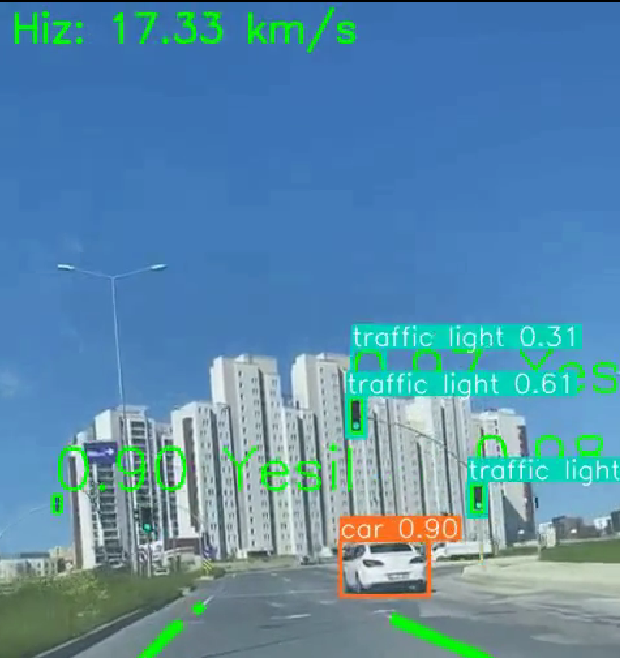 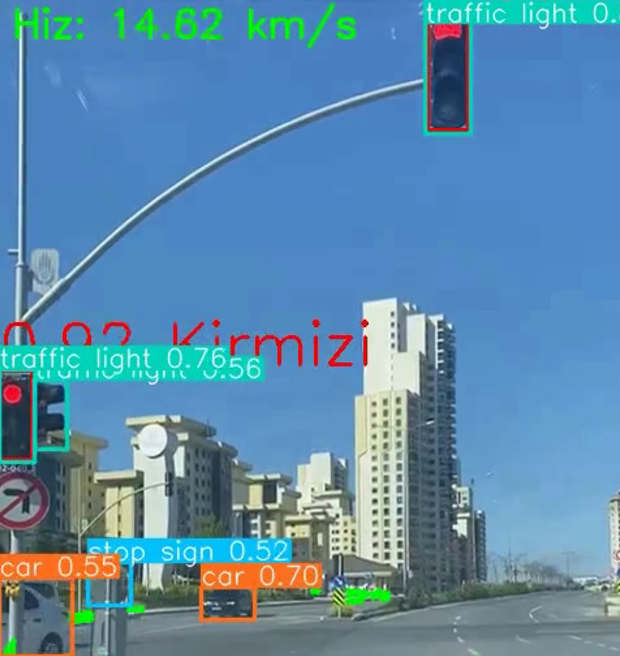 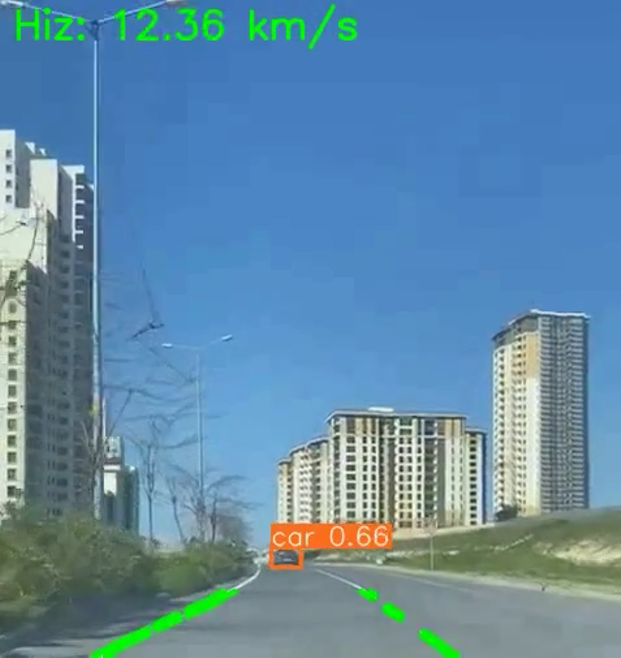 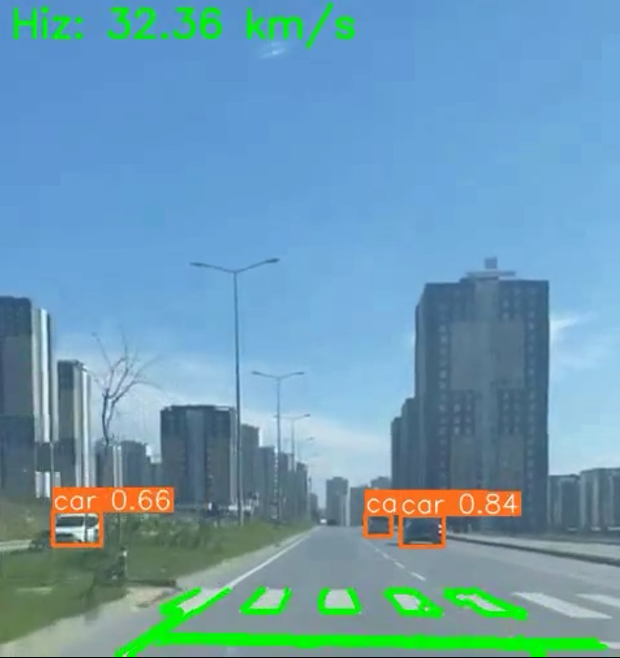 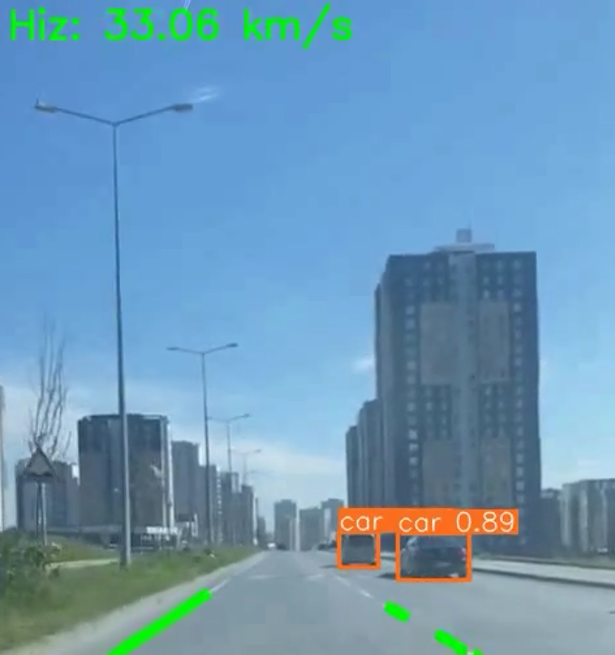 